### Step 0: To start ... 

In [168]:
# Turn on multi-threading on your computer for faster calculation 
%env OMP_NUM_THREADS = 4

env: OMP_NUM_THREADS=4


## Steps 1 and 2: Install and load the necessary packages and libraries

In [169]:
import numpy as np 
import pandas as pd

from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
import dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary

import matplotlib.pylab as plt

%matplotlib inline


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import statsmodels.api as sm
#from mord import LogisticIT #If you're looking for ordinal multi-class (more than 2 levels)
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
from scipy import stats
import math




## Step 3: Load the data

In [170]:
df = pd.read_csv('RMCase.csv', header = 0) #, encoding = "ISO-8859-1")

df.head() 

,ID,Program.Code,From.Grade,To.Grade,Group.State,Is.Non.Annual.,Days,Travel.Type,Departure.Date,Return.Date,Deposit.Date,Special.Pay,Tuition,FRP.Active,FRP.Cancelled,FRP.Take.up.percent.,Early.RPL,Latest.RPL,Cancelled.Pax,Total.Discount.Pax,Initial.System.Date,Poverty.Code,Region,CRM.Segment,School.Type,Parent.Meeting.Flag,MDR.Low.Grade,MDR.High.Grade,Total.School.Enrollment,Income.Level,EZ.Pay.Take.Up.Rate,School.Sponsor,SPR.Product.Type,SPR.New.Existing,FPP,Total.Pax,SPR.Group.Revenue,NumberOfMeetingswithParents,FirstMeeting,LastMeeting,DifferenceTraveltoFirstMeeting,DifferenceTraveltoLastMeeting,SchoolGradeTypeLow,SchoolGradeTypeHigh,SchoolGradeType,DepartureMonth,GroupGradeTypeLow,GroupGradeTypeHigh,GroupGradeType,MajorProgramCode,SingleGradeTripFlag,FPP.to.School.enrollment,FPP.to.PAX,Num.of.Non_FPP.PAX,SchoolSizeIndicator,Retained.in.2012.
0,1,HS,4.0,4.0,CA,0,1,A,1/14/11,1/14/11,8/30/10,NaN,424,25,3,0.424,3/29/10,8/12/10,3,4,3/26/10,B,Southern California,4.0,PUBLIC,1,K,5.0,927.0,Q,0.170,1,CA History,EXISTING,59,63,424,1,8/12/10,8/12/10,155.0,155.0,Elementary,Elementary,Elementary->Elementary,January,K,Elementary,K->Elementary,H,1,0.063646,0.936508,4,L,1
1,2,HC,8.0,8.0,AZ,0,7,A,1/14/11,1/21/11,11/15/09,CP,2350,9,9,0.409,10/20/09,8/10/10,11,3,10/2/09,C,Other,10.0,PUBLIC,1,7,8.0,850.0,A,0.091,0,East Coast,EXISTING,22,25,2350,2,11/17/09,8/27/10,423.0,140.0,Middle,Middle,Middle->Middle,January,Middle,Middle,Middle->Middle,H,1,0.025882,0.880000,3,L,1
2,3,HD,8.0,8.0,FL,0,3,A,1/15/11,1/17/11,10/15/10,NaN,1181,17,6,0.708,4/29/10,8/16/10,6,3,1/28/10,C,Other,10.0,PUBLIC,1,6,8.0,955.0,O,0.042,0,East Coast,EXISTING,24,27,1181,1,9/13/10,9/13/10,124.0,124.0,Middle,Middle,Middle->Middle,January,Middle,Middle,Middle->Middle,H,1,0.025131,0.888889,3,L,1
3,4,HN,9.0,12.0,VA,1,3,B,1/15/11,1/17/11,1/7/11,NaN,376,0,0,0.000,NaN,NaN,1,0,10/19/10,NaN,Other,7.0,CHD,0,NaN,NaN,NaN,NaN,0.000,0,East Coast,EXISTING,18,18,376,0,NaN,NaN,NaN,NaN,High,High,High->High,January,Undefined,Undefined,Undefined->Undefined,H,0,NaN,1.000000,0,NaN,0
4,5,HD,6.0,8.0,FL,0,6,T,1/16/11,1/21/11,9/30/10,NaN,865,40,8,0.494,3/29/10,8/12/10,9,8,3/23/10,D,Other,10.0,PUBLIC,1,6,8.0,720.0,C,0.383,0,East Coast,EXISTING,81,89,865,1,8/24/10,8/24/10,145.0,145.0,Middle,Middle,Middle->Middle,January,Middle,Middle,Middle->Middle,H,0,0.112500,0.910112,8,M-L,0


## Step 4: "Cleaning" the data

In this case the data are purposefully left slightly "dirty", that is, they are pre-cleaned somewhat, but for learning purposes some elements of dirty data still remain: 

1. Some datafields (variables, features, columns) have incorrect types -- they should be converted, for instance, from numbers to categoricals 
    
2. Some categorical variables have too many categories (levels), and some of the levels are too rare: for instance, there is only one group from Bahamas (why is this a problem?) -- such data should be merged into more populous category
    
3. Some data are missing and we need to replace or impute them 

To conclude data cleaning we will, of course, have to create dummy variables for the categorical variables
 

In [171]:
df.info() # Checking what kinds of data we have 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389 entries, 0 to 2388
Data columns (total 56 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              2389 non-null   int64  
 1   Program.Code                    2389 non-null   object 
 2   From.Grade                      2262 non-null   float64
 3   To.Grade                        2239 non-null   float64
 4   Group.State                     2389 non-null   object 
 5   Is.Non.Annual.                  2389 non-null   int64  
 6   Days                            2389 non-null   int64  
 7   Travel.Type                     2389 non-null   object 
 8   Departure.Date                  2389 non-null   object 
 9   Return.Date                     2389 non-null   object 
 10  Deposit.Date                    2389 non-null   object 
 11  Special.Pay                     470 non-null    object 
 12  Tuition                         23

In [172]:
# "Cleaning" the data -- part 1: converting data types that should be categorical into "category"

df['From.Grade'] = df['From.Grade'].astype('category')
df['To.Grade'] = df['To.Grade'].astype('category')
df['Is.Non.Annual.'] = df['Is.Non.Annual.'].astype('category')
df['Parent.Meeting.Flag'] = df['Parent.Meeting.Flag'].astype('category')
df['Days'] = df['Days'].astype('category')
df['CRM.Segment'] = df['CRM.Segment'].astype('category')
df['MDR.High.Grade'] = df['MDR.High.Grade'].astype('category')
df['School.Sponsor'] = df['School.Sponsor'].astype('category')
df['NumberOfMeetingswithParents'] = df['NumberOfMeetingswithParents'].astype('category')
df['SingleGradeTripFlag'] = df['SingleGradeTripFlag'].astype('category')
df['Travel.Type'] = df['Travel.Type'].astype('category')
df['Poverty.Code'] = df['Poverty.Code'].astype('category')
df['Region'] = df['Region'].astype('category')
df['School.Type'] = df['School.Type'].astype('category')
df['SPR.Product.Type'] = df['SPR.Product.Type'].astype('category')
df['SPR.New.Existing'] = df['SPR.New.Existing'].astype('category')
df['GroupGradeTypeLow'] = df['GroupGradeTypeLow'].astype('category')
df['GroupGradeTypeHigh'] = df['GroupGradeTypeHigh'].astype('category')
df['MajorProgramCode'] = df['MajorProgramCode'].astype('category')
df['SchoolSizeIndicator'] = df['SchoolSizeIndicator'].astype('category')


df.info() # let's check the result

#I only converted some variables which I thought would be useful. If you feel other variables that may be useful have their types incorrect, 
#please convert them too!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389 entries, 0 to 2388
Data columns (total 56 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   ID                              2389 non-null   int64   
 1   Program.Code                    2389 non-null   object  
 2   From.Grade                      2262 non-null   category
 3   To.Grade                        2239 non-null   category
 4   Group.State                     2389 non-null   object  
 5   Is.Non.Annual.                  2389 non-null   category
 6   Days                            2389 non-null   category
 7   Travel.Type                     2389 non-null   category
 8   Departure.Date                  2389 non-null   object  
 9   Return.Date                     2389 non-null   object  
 10  Deposit.Date                    2389 non-null   object  
 11  Special.Pay                     470 non-null    object  
 12  Tuition             

In [173]:
# "Cleaning" the data -- part 2: replacing/imputing missing data

pd.DataFrame(df).isna().sum() # Lets check if we have any missing data -- the result shows that yes, and a lot

ID                                   0
Program.Code                         0
From.Grade                         127
To.Grade                           150
Group.State                          0
Is.Non.Annual.                       0
Days                                 0
Travel.Type                          0
Departure.Date                       0
Return.Date                          0
Deposit.Date                         0
Special.Pay                       1919
Tuition                              0
FRP.Active                           0
FRP.Cancelled                        0
FRP.Take.up.percent.                 0
Early.RPL                          673
Latest.RPL                          19
Cancelled.Pax                        0
Total.Discount.Pax                   0
Initial.System.Date                  8
Poverty.Code                       599
Region                               0
CRM.Segment                          4
School.Type                          0
Parent.Meeting.Flag      

In [174]:
# "Cleaning" the data -- part 2: replacing/imputing missing data

# Approach:
# If a categorical feature is missing: add new category 'missing_value' 
# For Numerical features: replacing with 0 (or median, mean, or most frequent value, etc.) An alternative approach is to imputate, see here: https://scikit-learn.org/stable/modules/impute.html 

# fixing categoricals
imputer = SimpleImputer(missing_values = np.nan, strategy='constant',fill_value="Missing")
imputer.fit(df.select_dtypes(exclude=['int64','float64']))
df[df.select_dtypes(exclude=['int64','float64']).columns] = imputer.transform(df.select_dtypes(exclude=['int64','float64']))
           
# fixing numericals 
imputer = SimpleImputer(missing_values = np.nan, strategy='constant', fill_value=0)
imputer.fit(df.select_dtypes(include=['int64','float64']))
df[df.select_dtypes(include=['int64','float64']).columns] = imputer.transform(df.select_dtypes(include=['int64','float64']))

# Lets examine the result, e.g., datafield "Poverty.Code"
df[['Poverty.Code']]


,Poverty.Code
0,B
1,C
2,C
3,Missing
4,D
5,C
6,Missing
7,Missing
8,Missing
9,Missing


In [175]:
# "Cleaning" the data -- part 3: combining rare categories ("levels")

df['Group.State'].value_counts() # To get the intuition lets examine the column Group.State

# Here is the code to check all columns, in case you're interested
# for col in df.select_dtypes(include=['category','object','bool']).columns:
#    print(col)
#    print(df[col].value_counts())
#    print('\n') 


Group.State
CA                718
TX                308
WA                147
IL                104
CO                 89
MI                 71
FL                 62
AZ                 53
OH                 53
MN                 51
OR                 51
WI                 46
IN                 43
MO                 43
NE                 42
TN                 38
MA                 36
IA                 35
OK                 33
LA                 31
KS                 26
GA                 22
AL                 21
NV                 20
NM                 20
NY                 19
VA                 18
KY                 16
NC                 16
MD                 15
CT                 15
ID                 14
SD                 11
AR                 10
SC                 10
HI                  9
MS                  9
UT                  9
ME                  7
NH                  7
MT                  6
NJ                  6
AK                  5
PA                  5
ND                  

In [176]:
# "Cleaning" the data -- part 3: combining rare categories ("levels")

# Here is a custom function that we will call CombineRareCategories
# this function has two arguments: the name of the dataframe (data) and the minimal number of datapoints to remain a separate category (mincount)
# this function will loop through all the columns in the dataframe, and will combine all categories that appear in the data les than mincount number of times into (Other)

def CombineRareCategories(data, mincount):
    for col in data.columns:
        if (type(data[col][0]) == str):
            for index, row in pd.DataFrame(data[col].value_counts()).iterrows():
                if ( row[0] < mincount):
                    df[col].replace(index, 'Other_' + col, inplace = True)
                else:
                    None

# lets apply this functino to our data with mincount=20. You can try lowering this cut-off too!                    
CombineRareCategories(df, 20)        

df[0:10] #lets check the result

,ID,Program.Code,From.Grade,To.Grade,Group.State,Is.Non.Annual.,Days,Travel.Type,Departure.Date,Return.Date,Deposit.Date,Special.Pay,Tuition,FRP.Active,FRP.Cancelled,FRP.Take.up.percent.,Early.RPL,Latest.RPL,Cancelled.Pax,Total.Discount.Pax,Initial.System.Date,Poverty.Code,Region,CRM.Segment,School.Type,Parent.Meeting.Flag,MDR.Low.Grade,MDR.High.Grade,Total.School.Enrollment,Income.Level,EZ.Pay.Take.Up.Rate,School.Sponsor,SPR.Product.Type,SPR.New.Existing,FPP,Total.Pax,SPR.Group.Revenue,NumberOfMeetingswithParents,FirstMeeting,LastMeeting,DifferenceTraveltoFirstMeeting,DifferenceTraveltoLastMeeting,SchoolGradeTypeLow,SchoolGradeTypeHigh,SchoolGradeType,DepartureMonth,GroupGradeTypeLow,GroupGradeTypeHigh,GroupGradeType,MajorProgramCode,SingleGradeTripFlag,FPP.to.School.enrollment,FPP.to.PAX,Num.of.Non_FPP.PAX,SchoolSizeIndicator,Retained.in.2012.
0,1.0,HS,4.0,4.0,CA,0,1,A,Other_Departure.Date,Other_Return.Date,Other_Deposit.Date,Missing,424.0,25.0,3.0,0.424,3/29/10,8/12/10,3.0,4.0,3/26/10,B,Southern California,4.0,PUBLIC,1,K,5.0,927.0,Q,0.170,1,CA History,EXISTING,59.0,63.0,424.0,1,Other_FirstMeeting,Other_LastMeeting,155.0,155.0,Elementary,Elementary,Elementary->Elementary,Other_DepartureMonth,K,Elementary,K->Elementary,H,1,0.063646,0.936508,4.0,L,1.0
1,2.0,HC,8.0,8.0,AZ,0,7,A,Other_Departure.Date,Other_Return.Date,Other_Deposit.Date,CP,2350.0,9.0,9.0,0.409,Other_Early.RPL,8/10/10,11.0,3.0,Other_Initial.System.Date,C,Other,10.0,PUBLIC,1,7,8.0,850.0,A,0.091,0,East Coast,EXISTING,22.0,25.0,2350.0,2,Other_FirstMeeting,Other_LastMeeting,423.0,140.0,Middle,Middle,Middle->Middle,Other_DepartureMonth,Middle,Middle,Middle->Middle,H,1,0.025882,0.880000,3.0,L,1.0
2,3.0,HD,8.0,8.0,FL,0,3,A,Other_Departure.Date,Other_Return.Date,10/15/10,Missing,1181.0,17.0,6.0,0.708,4/29/10,8/16/10,6.0,3.0,1/28/10,C,Other,10.0,PUBLIC,1,6,8.0,955.0,O,0.042,0,East Coast,EXISTING,24.0,27.0,1181.0,1,9/13/10,9/13/10,124.0,124.0,Middle,Middle,Middle->Middle,Other_DepartureMonth,Middle,Middle,Middle->Middle,H,1,0.025131,0.888889,3.0,L,1.0
3,4.0,HN,9.0,12.0,Other_Group.State,1,3,B,Other_Departure.Date,Other_Return.Date,Other_Deposit.Date,Missing,376.0,0.0,0.0,0.000,Missing,Other_Latest.RPL,1.0,0.0,Other_Initial.System.Date,Missing,Other,7.0,CHD,0,Missing,Missing,0.0,Missing,0.000,0,East Coast,EXISTING,18.0,18.0,376.0,0,Missing,Missing,0.0,0.0,High,High,High->High,Other_DepartureMonth,Undefined,Undefined,Undefined->Undefined,H,0,0.000000,1.000000,0.0,Missing,0.0
4,5.0,HD,6.0,8.0,FL,0,6,Other_Travel.Type,Other_Departure.Date,Other_Return.Date,9/30/10,Missing,865.0,40.0,8.0,0.494,3/29/10,8/12/10,9.0,8.0,Other_Initial.System.Date,D,Other,10.0,PUBLIC,1,6,8.0,720.0,C,0.383,0,East Coast,EXISTING,81.0,89.0,865.0,1,Other_FirstMeeting,Other_LastMeeting,145.0,145.0,Middle,Middle,Middle->Middle,Other_DepartureMonth,Middle,Middle,Middle->Middle,H,0,0.112500,0.910112,8.0,M-L,0.0
5,6.0,HC,10.0,12.0,LA,0,4,A,Other_Departure.Date,Other_Return.Date,9/30/10,Missing,2025.0,9.0,4.0,0.900,Other_Early.RPL,Other_Latest.RPL,3.0,1.0,Other_Initial.System.Date,C,Other,8.0,PUBLIC,1,Other_MDR.Low.Grade,12.0,939.0,I,0.100,0,East Coast,NEW,10.0,11.0,2025.0,1,Other_FirstMeeting,Other_LastMeeting,91.0,91.0,High,High,High->High,Other_DepartureMonth,High,High,High->High,H,0,0.010650,0.909091,1.0,L,1.0
6,7.0,SG,11.0,12.0,MA,1,6,A,Other_Departure.Date,Other_Return.Date,10/15/10,Missing,1977.0,16.0,4.0,0.640,2/25/10,9/1/10,5.0,2.0,2/25/10,Missing,Other,8.0,Catholic,1,9,12.0,225.0,G,0.080,0,Science,EXISTING,25.0,27.0,1977.0,1,Other_FirstMeeting,Other_LastMeeting,63.0,63.0,High,High,High->High,Other_DepartureMonth,High,High,High->High,S,0,0.111111,0.925926,2.0,S,0.0
7,8.0,Other_Program.Code,9.0,9.0,Other_Group.State,0,8,A,Other_Departure.Date,Other_Return.Date,10/1/10,Missing,3379.0,10.0,0.0,0.769,Other_Early.RPL,8/23/10,1.0,1.0,Other_Initial.System.Date,Missing,Other,7.0,CHD,1,Missing,Missing,0.0,Missing,0.000,0,East Coast,EXISTING,13.0,14.0,3379.0,1,9/8/10,9/8/10,138.0,138.0,High,High,High->High,Othe

## The data is now ready to analyze!!
## Creating dummies for categorical variables

In [177]:
df1 = pd.get_dummies(df, columns=['From.Grade','To.Grade','Days', 'CRM.Segment','Travel.Type','Poverty.Code',
                                 'Region','School.Type','SPR.Product.Type','SPR.New.Existing','DepartureMonth',
                                 'GroupGradeTypeLow','GroupGradeTypeHigh','MajorProgramCode','SchoolSizeIndicator',
                                  'NumberOfMeetingswithParents'], 
                    prefix=['From.Grade','To.Grade','Days', 'CRM.Segment','Travel.Type','Poverty.Code',
                                 'Region','School.Type','SPR.Product.Type','SPR.New.Existing','DepartureMonth',
                                 'GroupGradeTypeLow','GroupGradeTypeHigh','MajorProgramCode','SchoolSizeIndicator',
                                  'NumberOfMeetingswithParents'], drop_first=False)



In [178]:
df1.columns

Index(['ID', 'Program.Code', 'Group.State', 'Is.Non.Annual.', 'Departure.Date',
       'Return.Date', 'Deposit.Date', 'Special.Pay', 'Tuition', 'FRP.Active',
       ...
       'MajorProgramCode_Other_MajorProgramCode', 'MajorProgramCode_S',
       'SchoolSizeIndicator_L', 'SchoolSizeIndicator_M-L',
       'SchoolSizeIndicator_Missing', 'SchoolSizeIndicator_S',
       'SchoolSizeIndicator_S-M', 'NumberOfMeetingswithParents_0',
       'NumberOfMeetingswithParents_1', 'NumberOfMeetingswithParents_2'],
      dtype='object', length=140)

In [179]:
column_names = df1.columns.tolist()
print(column_names)

['ID', 'Program.Code', 'Group.State', 'Is.Non.Annual.', 'Departure.Date', 'Return.Date', 'Deposit.Date', 'Special.Pay', 'Tuition', 'FRP.Active', 'FRP.Cancelled', 'FRP.Take.up.percent.', 'Early.RPL', 'Latest.RPL', 'Cancelled.Pax', 'Total.Discount.Pax', 'Initial.System.Date', 'Parent.Meeting.Flag', 'MDR.Low.Grade', 'MDR.High.Grade', 'Total.School.Enrollment', 'Income.Level', 'EZ.Pay.Take.Up.Rate', 'School.Sponsor', 'FPP', 'Total.Pax', 'SPR.Group.Revenue', 'FirstMeeting', 'LastMeeting', 'DifferenceTraveltoFirstMeeting', 'DifferenceTraveltoLastMeeting', 'SchoolGradeTypeLow', 'SchoolGradeTypeHigh', 'SchoolGradeType', 'GroupGradeType', 'SingleGradeTripFlag', 'FPP.to.School.enrollment', 'FPP.to.PAX', 'Num.of.Non_FPP.PAX', 'Retained.in.2012.', 'From.Grade_3.0', 'From.Grade_4.0', 'From.Grade_5.0', 'From.Grade_6.0', 'From.Grade_7.0', 'From.Grade_8.0', 'From.Grade_9.0', 'From.Grade_10.0', 'From.Grade_11.0', 'From.Grade_12.0', 'From.Grade_Missing', 'To.Grade_3.0', 'To.Grade_4.0', 'To.Grade_5.0', '

## KNN Model

In [180]:
#Partition the data into train and valid. Make sure you set seed
trainData = df1.sample(frac=0.6, random_state=1)
# sample 40% of the row IDs into the validation set, 
validData = df1.drop(trainData.index) 
trainData.shape

(1433, 140)

In [181]:
validData.shape

(956, 140)

## Initialize normalized training, validation data

In [182]:
scaler = preprocessing.StandardScaler()
scaler.fit(trainData[['Tuition','FRP.Active','FRP.Cancelled','FRP.Take.up.percent.','Cancelled.Pax',
                      'Total.Discount.Pax','Total.School.Enrollment', 'EZ.Pay.Take.Up.Rate','FPP',
                      'Total.Pax','SPR.Group.Revenue','DifferenceTraveltoFirstMeeting',
                      'FPP.to.School.enrollment']])  # Note the use of an array of column names

# Transform the full dataset
Norm_df = pd.concat([pd.DataFrame(scaler.transform(df1[['Tuition','FRP.Active','FRP.Cancelled','FRP.Take.up.percent.','Cancelled.Pax',
                      'Total.Discount.Pax','Total.School.Enrollment', 'EZ.Pay.Take.Up.Rate','FPP',
                      'Total.Pax','SPR.Group.Revenue','DifferenceTraveltoFirstMeeting',
                      'FPP.to.School.enrollment']]), 
            
            columns=['ZTuition','ZFRP.Active','ZFRP.Cancelled','ZFRP.Take.up.percent.','ZCancelled.Pax',
                      'ZTotal.Discount.Pax','ZTotal.School.Enrollment', 'ZEZ.Pay.Take.Up.Rate','ZFPP',
                      'ZTotal.Pax','ZSPR.Group.Revenue','ZDifferenceTraveltoFirstMeeting',
                      'ZFPP.to.School.enrollment']),
            
            df1[['Is.Non.Annual.','Parent.Meeting.Flag','School.Sponsor','SingleGradeTripFlag','From.Grade_3.0', 'From.Grade_4.0', 'From.Grade_5.0', 'From.Grade_6.0', 'From.Grade_7.0', 'From.Grade_8.0', 'From.Grade_9.0',
                'From.Grade_10.0', 'From.Grade_11.0', 'From.Grade_12.0', 'From.Grade_Missing', 'To.Grade_3.0', 'To.Grade_4.0', 'To.Grade_5.0',
                'To.Grade_6.0', 'To.Grade_7.0', 'To.Grade_8.0', 'To.Grade_9.0', 'To.Grade_10.0', 'To.Grade_11.0', 'To.Grade_12.0', 'To.Grade_Missing',
                'Days_1', 'Days_2', 'Days_3', 'Days_4', 'Days_5', 'Days_6', 'Days_7', 'Days_8', 'Days_9', 'Days_10', 'Days_11', 'Days_12', 
                'CRM.Segment_1.0', 'CRM.Segment_2.0', 'CRM.Segment_3.0', 'CRM.Segment_4.0', 'CRM.Segment_5.0', 'CRM.Segment_6.0', 'CRM.Segment_7.0',
                'CRM.Segment_8.0', 'CRM.Segment_9.0', 'CRM.Segment_10.0', 'CRM.Segment_11.0', 'CRM.Segment_Missing', 'Travel.Type_A', 'Travel.Type_B',
                'Travel.Type_Other_Travel.Type', 'Poverty.Code_A', 'Poverty.Code_B', 'Poverty.Code_C', 'Poverty.Code_D', 'Poverty.Code_Missing', 
                'Poverty.Code_Other_Poverty.Code', 'Region_Dallas', 'Region_Houston', 'Region_Northern California', 'Region_Other', 'Region_Pacific Northwest',
                'Region_Southern California', 'School.Type_CHD', 'School.Type_Catholic', 'School.Type_PUBLIC', 'School.Type_Private non-Christian',
                'SPR.Product.Type_CA History', 'SPR.Product.Type_Costa Rica', 'SPR.Product.Type_East Coast', 'SPR.Product.Type_Other_SPR.Product.Type',
                'SPR.Product.Type_Science', 'SPR.New.Existing_EXISTING', 'SPR.New.Existing_NEW', 'DepartureMonth_April', 'DepartureMonth_February', 
                'DepartureMonth_June', 'DepartureMonth_March', 'DepartureMonth_May', 'DepartureMonth_Other_DepartureMonth', 'GroupGradeTypeLow_Elementary',
                'GroupGradeTypeLow_High', 'GroupGradeTypeLow_K', 'GroupGradeTypeLow_Middle', 'GroupGradeTypeLow_PK', 'GroupGradeTypeLow_Undefined',
                'GroupGradeTypeHigh_Elementary', 'GroupGradeTypeHigh_High', 'GroupGradeTypeHigh_Middle', 'GroupGradeTypeHigh_Undefined', 'MajorProgramCode_C',
                'MajorProgramCode_H', 'MajorProgramCode_Other_MajorProgramCode', 'MajorProgramCode_S', 'SchoolSizeIndicator_L', 'SchoolSizeIndicator_M-L', 
                'SchoolSizeIndicator_Missing', 'SchoolSizeIndicator_S', 'SchoolSizeIndicator_S-M', 'NumberOfMeetingswithParents_0', 'NumberOfMeetingswithParents_1',
                'NumberOfMeetingswithParents_2','Retained.in.2012.']]], axis=1)



In [183]:
trainNorm = Norm_df.iloc[trainData.index]
#Similarly, get the valid one as well
validNorm = Norm_df.iloc[validData.index]
trainNorm.head()

,ZTuition,ZFRP.Active,ZFRP.Cancelled,ZFRP.Take.up.percent.,ZCancelled.Pax,ZTotal.Discount.Pax,ZTotal.School.Enrollment,ZEZ.Pay.Take.Up.Rate,ZFPP,ZTotal.Pax,ZSPR.Group.Revenue,ZDifferenceTraveltoFirstMeeting,ZFPP.to.School.enrollment,Is.Non.Annual.,Parent.Meeting.Flag,School.Sponsor,SingleGradeTripFlag,From.Grade_3.0,From.Grade_4.0,From.Grade_5.0,From.Grade_6.0,From.Grade_7.0,From.Grade_8.0,From.Grade_9.0,From.Grade_10.0,From.Grade_11.0,From.Grade_12.0,From.Grade_Missing,To.Grade_3.0,To.Grade_4.0,To.Grade_5.0,To.Grade_6.0,To.Grade_7.0,To.Grade_8.0,To.Grade_9.0,To.Grade_10.0,To.Grade_11.0,To.Grade_12.0,To.Grade_Missing,Days_1,Days_2,Days_3,Days_4,Days_5,Days_6,Days_7,Days_8,Days_9,Days_10,Days_11,Days_12,CRM.Segment_1.0,CRM.Segment_2.0,CRM.Segment_3.0,CRM.Segment_4.0,CRM.Segment_5.0,CRM.Segment_6.0,CRM.Segment_7.0,CRM.Segment_8.0,CRM.Segment_9.0,CRM.Segment_10.0,CRM.Segment_11.0,CRM.Segment_Missing,Travel.Type_A,Travel.Type_B,Travel.Type_Other_Travel.Type,Poverty.Code_A,Poverty.Code_B,Poverty.Code_C,Poverty.Code_D,Poverty.Code_Missing,Poverty.Code_Other_Poverty.Code,Region_Dallas,Region_Houston,Region_Northern California,Region_Other,Region_Pacific Northwest,Region_Southern California,School.Type_CHD,School.Type_Catholic,School.Type_PUBLIC,School.Type_Private non-Christian,SPR.Product.Type_CA History,SPR.Product.Type_Costa Rica,SPR.Product.Type_East Coast,SPR.Product.Type_Other_SPR.Product.Type,SPR.Product.Type_Science,SPR.New.Existing_EXISTING,SPR.New.Existing_NEW,DepartureMonth_April,DepartureMonth_February,DepartureMonth_June,DepartureMonth_March,DepartureMonth_May,DepartureMonth_Other_DepartureMonth,GroupGradeTypeLow_Elementary,GroupGradeTypeLow_High,GroupGradeTypeLow_K,GroupGradeTypeLow_Middle,GroupGradeTypeLow_PK,GroupGradeTypeLow_Undefined,GroupGradeTypeHigh_Elementary,GroupGradeTypeHigh_High,GroupGradeTypeHigh_Middle,GroupGradeTypeHigh_Undefined,MajorProgramCode_C,MajorProgramCode_H,MajorProgramCode_Other_MajorProgramCode,MajorProgramCode_S,SchoolSizeIndicator_L,SchoolSizeIndicator_M-L,SchoolSizeIndicator_Missing,SchoolSizeIndicator_S,SchoolSizeIndicator_S-M,NumberOfMeetingswithParents_0,NumberOfMeetingswithParents_1,NumberOfMeetingswithParents_2,Retained.in.2012.
1145,-1.169506,0.346054,0.738671,-0.742107,0.039150,0.728622,0.240561,-0.442411,0.871806,0.869706,-1.169506,0.032786,0.181512,0,1,0,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,1.0
899,0.439159,0.915720,0.463446,-0.720288,0.691504,1.444995,1.119149,0.776257,1.666356,1.666821,0.439159,-0.008947,0.117768,0,1,1,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,True,False,1.0
1813,0.226224,-0.679346,-0.637454,0.252834,-0.830655,-0.704126,-0.838448,-1.322915,-0.783507,-0.785840,0.226224,0.174679,-0.373877,0,1,0,1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False

In [184]:
validNorm.head()

,ZTuition,ZFRP.Active,ZFRP.Cancelled,ZFRP.Take.up.percent.,ZCancelled.Pax,ZTotal.Discount.Pax,ZTotal.School.Enrollment,ZEZ.Pay.Take.Up.Rate,ZFPP,ZTotal.Pax,ZSPR.Group.Revenue,ZDifferenceTraveltoFirstMeeting,ZFPP.to.School.enrollment,Is.Non.Annual.,Parent.Meeting.Flag,School.Sponsor,SingleGradeTripFlag,From.Grade_3.0,From.Grade_4.0,From.Grade_5.0,From.Grade_6.0,From.Grade_7.0,From.Grade_8.0,From.Grade_9.0,From.Grade_10.0,From.Grade_11.0,From.Grade_12.0,From.Grade_Missing,To.Grade_3.0,To.Grade_4.0,To.Grade_5.0,To.Grade_6.0,To.Grade_7.0,To.Grade_8.0,To.Grade_9.0,To.Grade_10.0,To.Grade_11.0,To.Grade_12.0,To.Grade_Missing,Days_1,Days_2,Days_3,Days_4,Days_5,Days_6,Days_7,Days_8,Days_9,Days_10,Days_11,Days_12,CRM.Segment_1.0,CRM.Segment_2.0,CRM.Segment_3.0,CRM.Segment_4.0,CRM.Segment_5.0,CRM.Segment_6.0,CRM.Segment_7.0,CRM.Segment_8.0,CRM.Segment_9.0,CRM.Segment_10.0,CRM.Segment_11.0,CRM.Segment_Missing,Travel.Type_A,Travel.Type_B,Travel.Type_Other_Travel.Type,Poverty.Code_A,Poverty.Code_B,Poverty.Code_C,Poverty.Code_D,Poverty.Code_Missing,Poverty.Code_Other_Poverty.Code,Region_Dallas,Region_Houston,Region_Northern California,Region_Other,Region_Pacific Northwest,Region_Southern California,School.Type_CHD,School.Type_Catholic,School.Type_PUBLIC,School.Type_Private non-Christian,SPR.Product.Type_CA History,SPR.Product.Type_Costa Rica,SPR.Product.Type_East Coast,SPR.Product.Type_Other_SPR.Product.Type,SPR.Product.Type_Science,SPR.New.Existing_EXISTING,SPR.New.Existing_NEW,DepartureMonth_April,DepartureMonth_February,DepartureMonth_June,DepartureMonth_March,DepartureMonth_May,DepartureMonth_Other_DepartureMonth,GroupGradeTypeLow_Elementary,GroupGradeTypeLow_High,GroupGradeTypeLow_K,GroupGradeTypeLow_Middle,GroupGradeTypeLow_PK,GroupGradeTypeLow_Undefined,GroupGradeTypeHigh_Elementary,GroupGradeTypeHigh_High,GroupGradeTypeHigh_Middle,GroupGradeTypeHigh_Undefined,MajorProgramCode_C,MajorProgramCode_H,MajorProgramCode_Other_MajorProgramCode,MajorProgramCode_S,SchoolSizeIndicator_L,SchoolSizeIndicator_M-L,SchoolSizeIndicator_Missing,SchoolSizeIndicator_S,SchoolSizeIndicator_S-M,NumberOfMeetingswithParents_0,NumberOfMeetingswithParents_1,NumberOfMeetingswithParents_2,Retained.in.2012.
2,-0.676804,0.004254,0.738671,0.615027,0.256602,0.012248,0.781230,-1.054936,-0.253807,-0.233991,-0.676804,-0.835260,-0.437201,0,1,0,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,False,1.0
4,-1.167952,1.314487,1.289121,-0.318821,0.908956,1.803182,0.233569,1.120802,1.633250,1.666821,-1.167952,-0.659982,0.544030,0,1,0,0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,0.0
5,0.634996,-0.451480,0.188221,1.452872,-0.395752,-0.704126,0.743943,-0.684869,-0.717295,-0.724523,0.634996,-1.110698,-0.599838,0,1,0,0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,Fa

## Finding the best k
## Initialize a data frame with two columns: `k` and `accuracy`

In [185]:
train_X = trainNorm[['ZTuition','ZFRP.Active','ZFRP.Cancelled','ZFRP.Take.up.percent.','ZCancelled.Pax',
                      'ZTotal.Discount.Pax','ZTotal.School.Enrollment', 'ZEZ.Pay.Take.Up.Rate','ZFPP',
                      'ZTotal.Pax','ZSPR.Group.Revenue','ZDifferenceTraveltoFirstMeeting', 
                      'ZFPP.to.School.enrollment','Is.Non.Annual.','Parent.Meeting.Flag','School.Sponsor','SingleGradeTripFlag',
                'From.Grade_3.0', 'From.Grade_4.0', 'From.Grade_5.0', 'From.Grade_6.0', 'From.Grade_7.0', 'From.Grade_8.0', 'From.Grade_9.0',
                'From.Grade_10.0', 'From.Grade_11.0', 'From.Grade_12.0', 'From.Grade_Missing', 'To.Grade_3.0', 'To.Grade_4.0', 'To.Grade_5.0',
                'To.Grade_6.0', 'To.Grade_7.0', 'To.Grade_8.0', 'To.Grade_9.0', 'To.Grade_10.0', 'To.Grade_11.0', 'To.Grade_12.0', 'To.Grade_Missing',
                'Days_1', 'Days_2', 'Days_3', 'Days_4', 'Days_5', 'Days_6', 'Days_7', 'Days_8', 'Days_9', 'Days_10', 'Days_11', 'Days_12', 
                'CRM.Segment_1.0', 'CRM.Segment_2.0', 'CRM.Segment_3.0', 'CRM.Segment_4.0', 'CRM.Segment_5.0', 'CRM.Segment_6.0', 'CRM.Segment_7.0',
                'CRM.Segment_8.0', 'CRM.Segment_9.0', 'CRM.Segment_10.0', 'CRM.Segment_11.0', 'CRM.Segment_Missing', 'Travel.Type_A', 'Travel.Type_B',
                'Travel.Type_Other_Travel.Type', 'Poverty.Code_A', 'Poverty.Code_B', 'Poverty.Code_C', 'Poverty.Code_D', 'Poverty.Code_Missing', 
                'Poverty.Code_Other_Poverty.Code', 'Region_Dallas', 'Region_Houston', 'Region_Northern California', 'Region_Other', 'Region_Pacific Northwest',
                'Region_Southern California', 'School.Type_CHD', 'School.Type_Catholic', 'School.Type_PUBLIC', 'School.Type_Private non-Christian',
                'SPR.Product.Type_CA History', 'SPR.Product.Type_Costa Rica', 'SPR.Product.Type_East Coast', 'SPR.Product.Type_Other_SPR.Product.Type',
                'SPR.Product.Type_Science', 'SPR.New.Existing_EXISTING', 'SPR.New.Existing_NEW', 'DepartureMonth_April', 'DepartureMonth_February', 
                'DepartureMonth_June', 'DepartureMonth_March', 'DepartureMonth_May', 'DepartureMonth_Other_DepartureMonth', 'GroupGradeTypeLow_Elementary',
                'GroupGradeTypeLow_High', 'GroupGradeTypeLow_K', 'GroupGradeTypeLow_Middle', 'GroupGradeTypeLow_PK', 'GroupGradeTypeLow_Undefined',
                'GroupGradeTypeHigh_Elementary', 'GroupGradeTypeHigh_High', 'GroupGradeTypeHigh_Middle', 'GroupGradeTypeHigh_Undefined', 'MajorProgramCode_C',
                'MajorProgramCode_H', 'MajorProgramCode_Other_MajorProgramCode', 'MajorProgramCode_S', 'SchoolSizeIndicator_L', 'SchoolSizeIndicator_M-L', 
                'SchoolSizeIndicator_Missing', 'SchoolSizeIndicator_S', 'SchoolSizeIndicator_S-M', 'NumberOfMeetingswithParents_0', 'NumberOfMeetingswithParents_1',
                'NumberOfMeetingswithParents_2']]

train_y = trainNorm['Retained.in.2012.']

valid_X = validNorm[['ZTuition','ZFRP.Active','ZFRP.Cancelled','ZFRP.Take.up.percent.','ZCancelled.Pax',
                      'ZTotal.Discount.Pax','ZTotal.School.Enrollment', 'ZEZ.Pay.Take.Up.Rate','ZFPP',
                      'ZTotal.Pax','ZSPR.Group.Revenue','ZDifferenceTraveltoFirstMeeting',
                      'ZFPP.to.School.enrollment','Is.Non.Annual.','Parent.Meeting.Flag','School.Sponsor','SingleGradeTripFlag',
                'From.Grade_3.0', 'From.Grade_4.0', 'From.Grade_5.0', 'From.Grade_6.0', 'From.Grade_7.0', 'From.Grade_8.0', 'From.Grade_9.0',
                'From.Grade_10.0', 'From.Grade_11.0', 'From.Grade_12.0', 'From.Grade_Missing', 'To.Grade_3.0', 'To.Grade_4.0', 'To.Grade_5.0',
                'To.Grade_6.0', 'To.Grade_7.0', 'To.Grade_8.0', 'To.Grade_9.0', 'To.Grade_10.0', 'To.Grade_11.0', 'To.Grade_12.0', 'To.Grade_Missing',
                'Days_1', 'Days_2', 'Days_3', 'Days_4', 'Days_5', 'Days_6', 'Days_7', 'Days_8', 'Days_9', 'Days_10', 'Days_11', 'Days_12', 
                'CRM.Segment_1.0', 'CRM.Segment_2.0', 'CRM.Segment_3.0', 'CRM.Segment_4.0', 'CRM.Segment_5.0', 'CRM.Segment_6.0', 'CRM.Segment_7.0',
                'CRM.Segment_8.0', 'CRM.Segment_9.0', 'CRM.Segment_10.0', 'CRM.Segment_11.0', 'CRM.Segment_Missing', 'Travel.Type_A', 'Travel.Type_B',
                'Travel.Type_Other_Travel.Type', 'Poverty.Code_A', 'Poverty.Code_B', 'Poverty.Code_C', 'Poverty.Code_D', 'Poverty.Code_Missing', 
                'Poverty.Code_Other_Poverty.Code', 'Region_Dallas', 'Region_Houston', 'Region_Northern California', 'Region_Other', 'Region_Pacific Northwest',
                'Region_Southern California', 'School.Type_CHD', 'School.Type_Catholic', 'School.Type_PUBLIC', 'School.Type_Private non-Christian',
                'SPR.Product.Type_CA History', 'SPR.Product.Type_Costa Rica', 'SPR.Product.Type_East Coast', 'SPR.Product.Type_Other_SPR.Product.Type',
                'SPR.Product.Type_Science', 'SPR.New.Existing_EXISTING', 'SPR.New.Existing_NEW', 'DepartureMonth_April', 'DepartureMonth_February', 
                'DepartureMonth_June', 'DepartureMonth_March', 'DepartureMonth_May', 'DepartureMonth_Other_DepartureMonth', 'GroupGradeTypeLow_Elementary',
                'GroupGradeTypeLow_High', 'GroupGradeTypeLow_K', 'GroupGradeTypeLow_Middle', 'GroupGradeTypeLow_PK', 'GroupGradeTypeLow_Undefined',
                'GroupGradeTypeHigh_Elementary', 'GroupGradeTypeHigh_High', 'GroupGradeTypeHigh_Middle', 'GroupGradeTypeHigh_Undefined', 'MajorProgramCode_C',
                'MajorProgramCode_H', 'MajorProgramCode_Other_MajorProgramCode', 'MajorProgramCode_S', 'SchoolSizeIndicator_L', 'SchoolSizeIndicator_M-L', 
                'SchoolSizeIndicator_Missing', 'SchoolSizeIndicator_S', 'SchoolSizeIndicator_S-M', 'NumberOfMeetingswithParents_0', 'NumberOfMeetingswithParents_1',
                'NumberOfMeetingswithParents_2']]

valid_y = validNorm['Retained.in.2012.']

# Train a classifier for different values of k
results = []
for k in range(1, 38):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X.values, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X.values))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1  0.663180
1    2  0.645397
2    3  0.707113
3    4  0.699791
4    5  0.729079
5    6  0.722803
6    7  0.737448
7    8  0.740586
8    9  0.740586
9   10  0.748954
10  11  0.747908
11  12  0.753138
12  13  0.752092
13  14  0.744770
14  15  0.752092
15  16  0.750000
16  17  0.743724
17  18  0.757322
18  19  0.755230
19  20  0.758368
20  21  0.758368
21  22  0.759414
22  23  0.762552
23  24  0.770921
24  25  0.756276
25  26  0.761506
26  27  0.759414
27  28  0.761506
28  29  0.757322
29  30  0.764644
30  31  0.756276
31  32  0.759414
32  33  0.750000
33  34  0.744770
34  35  0.742678
35  36  0.743724
36  37  0.737448


## Retrain with full dataset using the best k

In [186]:

full_X = Norm_df[['ZTuition','ZFRP.Active','ZFRP.Cancelled','ZFRP.Take.up.percent.','ZCancelled.Pax',
                      'ZTotal.Discount.Pax','ZTotal.School.Enrollment', 'ZEZ.Pay.Take.Up.Rate','ZFPP',
                      'ZTotal.Pax','ZSPR.Group.Revenue','ZDifferenceTraveltoFirstMeeting',
                      'ZFPP.to.School.enrollment','Is.Non.Annual.','Parent.Meeting.Flag','School.Sponsor','SingleGradeTripFlag',
                'From.Grade_3.0', 'From.Grade_4.0', 'From.Grade_5.0', 'From.Grade_6.0', 'From.Grade_7.0', 'From.Grade_8.0', 'From.Grade_9.0',
                'From.Grade_10.0', 'From.Grade_11.0', 'From.Grade_12.0', 'From.Grade_Missing', 'To.Grade_3.0', 'To.Grade_4.0', 'To.Grade_5.0',
                'To.Grade_6.0', 'To.Grade_7.0', 'To.Grade_8.0', 'To.Grade_9.0', 'To.Grade_10.0', 'To.Grade_11.0', 'To.Grade_12.0', 'To.Grade_Missing',
                'Days_1', 'Days_2', 'Days_3', 'Days_4', 'Days_5', 'Days_6', 'Days_7', 'Days_8', 'Days_9', 'Days_10', 'Days_11', 'Days_12', 
                'CRM.Segment_1.0', 'CRM.Segment_2.0', 'CRM.Segment_3.0', 'CRM.Segment_4.0', 'CRM.Segment_5.0', 'CRM.Segment_6.0', 'CRM.Segment_7.0',
                'CRM.Segment_8.0', 'CRM.Segment_9.0', 'CRM.Segment_10.0', 'CRM.Segment_11.0', 'CRM.Segment_Missing', 'Travel.Type_A', 'Travel.Type_B',
                'Travel.Type_Other_Travel.Type', 'Poverty.Code_A', 'Poverty.Code_B', 'Poverty.Code_C', 'Poverty.Code_D', 'Poverty.Code_Missing', 
                'Poverty.Code_Other_Poverty.Code', 'Region_Dallas', 'Region_Houston', 'Region_Northern California', 'Region_Other', 'Region_Pacific Northwest',
                'Region_Southern California', 'School.Type_CHD', 'School.Type_Catholic', 'School.Type_PUBLIC', 'School.Type_Private non-Christian',
                'SPR.Product.Type_CA History', 'SPR.Product.Type_Costa Rica', 'SPR.Product.Type_East Coast', 'SPR.Product.Type_Other_SPR.Product.Type',
                'SPR.Product.Type_Science', 'SPR.New.Existing_EXISTING', 'SPR.New.Existing_NEW', 'DepartureMonth_April', 'DepartureMonth_February', 
                'DepartureMonth_June', 'DepartureMonth_March', 'DepartureMonth_May', 'DepartureMonth_Other_DepartureMonth', 'GroupGradeTypeLow_Elementary',
                'GroupGradeTypeLow_High', 'GroupGradeTypeLow_K', 'GroupGradeTypeLow_Middle', 'GroupGradeTypeLow_PK', 'GroupGradeTypeLow_Undefined',
                'GroupGradeTypeHigh_Elementary', 'GroupGradeTypeHigh_High', 'GroupGradeTypeHigh_Middle', 'GroupGradeTypeHigh_Undefined', 'MajorProgramCode_C',
                'MajorProgramCode_H', 'MajorProgramCode_Other_MajorProgramCode', 'MajorProgramCode_S', 'SchoolSizeIndicator_L', 'SchoolSizeIndicator_M-L', 
                'SchoolSizeIndicator_Missing', 'SchoolSizeIndicator_S', 'SchoolSizeIndicator_S-M', 'NumberOfMeetingswithParents_0', 'NumberOfMeetingswithParents_1',
                'NumberOfMeetingswithParents_2']]

full_y = Norm_df['Retained.in.2012.']

best_knn = KNeighborsClassifier(n_neighbors=24).fit(full_X.values, full_y)


## Prediction for New Data

In [187]:
# Copy the row at index 0 to create a new row
new_data_point = Norm_df.iloc[0].copy()

# Exclude 'Retained.in.2012.' from the modified row
new_data_point.drop('Retained.in.2012.', inplace=True, errors='ignore')

# Alter specific columns for the new data point
new_data_point['Parent.Meeting.Flag'] = 0
new_data_point['School.Sponsor'] = 0
new_data_point['SingleGradeTripFlag'] = 0
new_data_point['Is.Non.Annual.'] = 1

In [188]:
new_data_point = np.array(new_data_point).reshape(1, -1)

In [189]:
distances, indices = best_knn.kneighbors(new_data_point) 
print(best_knn.predict(new_data_point)) 
print('Distances',distances) 
print('Indices', indices) 
print(Norm_df.iloc[indices[0], :])

[1.]
Distances [[2.         3.1606615  3.28035602 3.40416039 3.4814279  3.64332747
  3.66844678 3.72245002 3.74790688 3.82321911 3.83988578 3.87680711
  3.88979723 3.89657675 3.92781683 3.930382   3.951451   3.9556162
  3.98179499 3.98400932 4.07389974 4.10760717 4.11392514 4.11688415]]
Indices [[   0 1240  961 1736  718  960  332 1101  239 1602  345 1939 1239  578
   348  771 1581 1557 1927 1583  594  311 1926 1416]]
      ZTuition  ZFRP.Active  ZFRP.Cancelled  ZFRP.Take.up.percent.  \
0    -1.853383     0.459987       -0.087004              -0.624285   
1240 -1.892239     0.289087       -0.362229              -0.432279   
961  -1.887576     0.915720        0.463446               0.052100   
1736 -1.847165     0.573920        0.738671               0.204832   
718  -1.893793     0.175154       -0.362229               0.017190   
960  -1.901565     0.459987       -0.912679              -0.794472   
332  -1.929542     0.004254       -0.362229              -1.099936   
1101 -1.912445    

# Classification Tree

In [190]:
X = df1[['Tuition','FRP.Active','FRP.Cancelled','FRP.Take.up.percent.','Cancelled.Pax',
                      'Total.Discount.Pax','Total.School.Enrollment', 'EZ.Pay.Take.Up.Rate','FPP',
                      'Total.Pax','SPR.Group.Revenue','DifferenceTraveltoFirstMeeting',
                      'FPP.to.School.enrollment','Is.Non.Annual.','Parent.Meeting.Flag','School.Sponsor','SingleGradeTripFlag',
                'From.Grade_3.0', 'From.Grade_4.0', 'From.Grade_5.0', 'From.Grade_6.0', 'From.Grade_7.0', 'From.Grade_8.0', 'From.Grade_9.0',
                'From.Grade_10.0', 'From.Grade_11.0', 'From.Grade_12.0', 'From.Grade_Missing', 'To.Grade_3.0', 'To.Grade_4.0', 'To.Grade_5.0',
                'To.Grade_6.0', 'To.Grade_7.0', 'To.Grade_8.0', 'To.Grade_9.0', 'To.Grade_10.0', 'To.Grade_11.0', 'To.Grade_12.0', 'To.Grade_Missing',
                'Days_1', 'Days_2', 'Days_3', 'Days_4', 'Days_5', 'Days_6', 'Days_7', 'Days_8', 'Days_9', 'Days_10', 'Days_11', 'Days_12', 
                'CRM.Segment_1.0', 'CRM.Segment_2.0', 'CRM.Segment_3.0', 'CRM.Segment_4.0', 'CRM.Segment_5.0', 'CRM.Segment_6.0', 'CRM.Segment_7.0',
                'CRM.Segment_8.0', 'CRM.Segment_9.0', 'CRM.Segment_10.0', 'CRM.Segment_11.0', 'CRM.Segment_Missing', 'Travel.Type_A', 'Travel.Type_B',
                'Travel.Type_Other_Travel.Type', 'Poverty.Code_A', 'Poverty.Code_B', 'Poverty.Code_C', 'Poverty.Code_D', 'Poverty.Code_Missing', 
                'Poverty.Code_Other_Poverty.Code', 'Region_Dallas', 'Region_Houston', 'Region_Northern California', 'Region_Other', 'Region_Pacific Northwest',
                'Region_Southern California', 'School.Type_CHD', 'School.Type_Catholic', 'School.Type_PUBLIC', 'School.Type_Private non-Christian',
                'SPR.Product.Type_CA History', 'SPR.Product.Type_Costa Rica', 'SPR.Product.Type_East Coast', 'SPR.Product.Type_Other_SPR.Product.Type',
                'SPR.Product.Type_Science', 'SPR.New.Existing_EXISTING', 'SPR.New.Existing_NEW', 'DepartureMonth_April', 'DepartureMonth_February', 
                'DepartureMonth_June', 'DepartureMonth_March', 'DepartureMonth_May', 'DepartureMonth_Other_DepartureMonth', 'GroupGradeTypeLow_Elementary',
                'GroupGradeTypeLow_High', 'GroupGradeTypeLow_K', 'GroupGradeTypeLow_Middle', 'GroupGradeTypeLow_PK', 'GroupGradeTypeLow_Undefined',
                'GroupGradeTypeHigh_Elementary', 'GroupGradeTypeHigh_High', 'GroupGradeTypeHigh_Middle', 'GroupGradeTypeHigh_Undefined', 'MajorProgramCode_C',
                'MajorProgramCode_H', 'MajorProgramCode_Other_MajorProgramCode', 'MajorProgramCode_S', 'SchoolSizeIndicator_L', 'SchoolSizeIndicator_M-L', 
                'SchoolSizeIndicator_Missing', 'SchoolSizeIndicator_S', 'SchoolSizeIndicator_S-M', 'NumberOfMeetingswithParents_0', 'NumberOfMeetingswithParents_1',
                'NumberOfMeetingswithParents_2']]

y = df1['Retained.in.2012.']

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)


## Grid Search

In [191]:
# Start with an initial guess for parameters
param_grid = {
    'max_depth': [10, 20, 30, 40], 
    'min_samples_split': [20, 40, 60, 80, 100], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1) #n_jobs=-1 means 
        #that the availalbe computer memory (CPU) will be used to make calculations faster. 
gridSearch.fit(train_X, train_y)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(2, 16)), 
    'min_samples_split': list(range(90, 110)), 
    'min_impurity_decrease': [0.0009, 0.005, 0.0011], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

Initial score:  0.8011281401525304
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0.005, 'min_samples_split': 100}
Improved score:  0.8032211690748277
Improved parameters:  {'max_depth': 4, 'min_impurity_decrease': 0.0009, 'min_samples_split': 103}


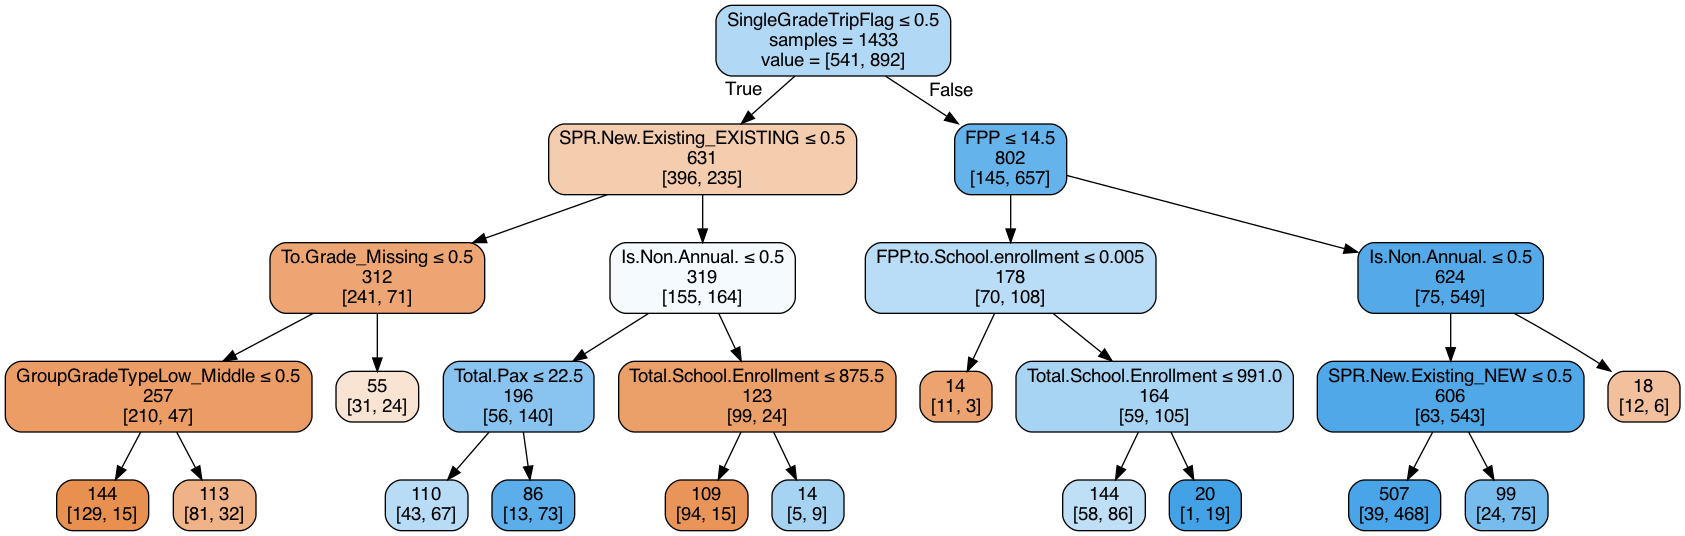

In [192]:
plotDecisionTree(bestClassTree, feature_names=train_X.columns)

In [193]:
classificationSummary(train_y, bestClassTree.predict(train_X))
classificationSummary(valid_y, bestClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8060)

       Prediction
Actual   0   1
     0 358 183
     1  95 797
Confusion Matrix (Accuracy 0.7845)

       Prediction
Actual   0   1
     0 257 140
     1  66 493


## Random Forest

In [194]:
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)

RandomForestClassifier(n_estimators=500, random_state=1)

## Variable Importance plot

                                     feature  importance       std
28                              To.Grade_3.0    0.000000  0.000000
50                                   Days_12    0.000000  0.000000
17                            From.Grade_3.0    0.000066  0.000465
62                       CRM.Segment_Missing    0.000096  0.000595
47                                    Days_9    0.000142  0.000669
107  MajorProgramCode_Other_MajorProgramCode    0.000221  0.001276
48                                   Days_10    0.000225  0.000899
49                                   Days_11    0.000225  0.000814
85   SPR.Product.Type_Other_SPR.Product.Type    0.000229  0.000921
36                             To.Grade_11.0    0.000380  0.001191
61                          CRM.Segment_11.0    0.000448  0.001320
26                           From.Grade_12.0    0.000467  0.001314
53                           CRM.Segment_3.0    0.000561  0.001408
25                           From.Grade_11.0    0.000644  0.00

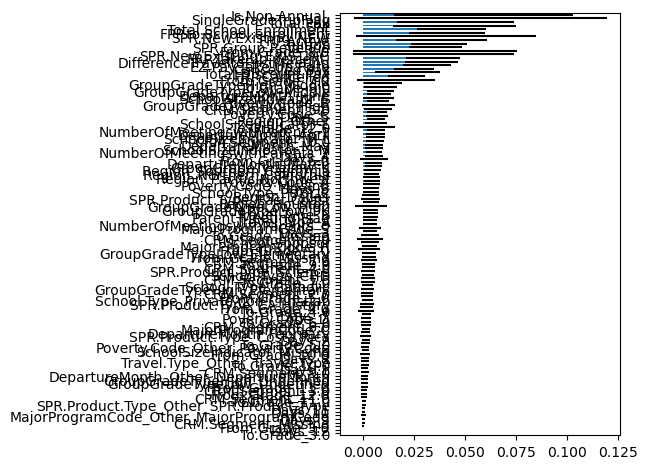

In [195]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

variables_df = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
variables_df = variables_df.sort_values('importance')
print(variables_df)
variables_df.to_csv('variables_list.csv', index=True)

ax = variables_df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [196]:
classificationSummary(valid_y, rf.predict(valid_X))

Confusion Matrix (Accuracy 0.7897)

       Prediction
Actual   0   1
     0 261 136
     1  65 494


## Boosted Trees

In [197]:
boost = GradientBoostingClassifier()
boost.fit(train_X, train_y)

GradientBoostingClassifier()

In [198]:
classificationSummary(valid_y, boost.predict(valid_X))

Confusion Matrix (Accuracy 0.7981)

       Prediction
Actual   0   1
     0 276 121
     1  72 487


## Logit

## Creating dummies for categorical variables

In [200]:
df2 = pd.get_dummies(df, columns=['From.Grade','To.Grade','Days', 'CRM.Segment','Travel.Type','Poverty.Code',
                                 'Region','School.Type','SPR.Product.Type','SPR.New.Existing','DepartureMonth',
                                 'GroupGradeTypeLow','GroupGradeTypeHigh','MajorProgramCode','SchoolSizeIndicator',
                                  'NumberOfMeetingswithParents'], 
                    prefix=['From.Grade','To.Grade','Days', 'CRM.Segment','Travel.Type','Poverty.Code',
                                 'Region','School.Type','SPR.Product.Type','SPR.New.Existing','DepartureMonth',
                                 'GroupGradeTypeLow','GroupGradeTypeHigh','MajorProgramCode','SchoolSizeIndicator',
                                  'NumberOfMeetingswithParents'], drop_first=True, dtype=int)
df2.head()



,ID,Program.Code,Group.State,Is.Non.Annual.,Departure.Date,Return.Date,Deposit.Date,Special.Pay,Tuition,FRP.Active,FRP.Cancelled,FRP.Take.up.percent.,Early.RPL,Latest.RPL,Cancelled.Pax,Total.Discount.Pax,Initial.System.Date,Parent.Meeting.Flag,MDR.Low.Grade,MDR.High.Grade,Total.School.Enrollment,Income.Level,EZ.Pay.Take.Up.Rate,School.Sponsor,FPP,Total.Pax,SPR.Group.Revenue,FirstMeeting,LastMeeting,DifferenceTraveltoFirstMeeting,DifferenceTraveltoLastMeeting,SchoolGradeTypeLow,SchoolGradeTypeHigh,SchoolGradeType,GroupGradeType,SingleGradeTripFlag,FPP.to.School.enrollment,FPP.to.PAX,Num.of.Non_FPP.PAX,Retained.in.2012.,From.Grade_4.0,From.Grade_5.0,From.Grade_6.0,From.Grade_7.0,From.Grade_8.0,From.Grade_9.0,From.Grade_10.0,From.Grade_11.0,From.Grade_12.0,From.Grade_Missing,To.Grade_4.0,To.Grade_5.0,To.Grade_6.0,To.Grade_7.0,To.Grade_8.0,To.Grade_9.0,To.Grade_10.0,To.Grade_11.0,To.Grade_12.0,To.Grade_Missing,Days_2,Days_3,Days_4,Days_5,Days_6,Days_7,Days_8,Days_9,Days_10,Days_11,Days_12,CRM.Segment_2.0,CRM.Segment_3.0,CRM.Segment_4.0,CRM.Segment_5.0,CRM.Segment_6.0,CRM.Segment_7.0,CRM.Segment_8.0,CRM.Segment_9.0,CRM.Segment_10.0,CRM.Segment_11.0,CRM.Segment_Missing,Travel.Type_B,Travel.Type_Other_Travel.Type,Poverty.Code_B,Poverty.Code_C,Poverty.Code_D,Poverty.Code_Missing,Poverty.Code_Other_Poverty.Code,Region_Houston,Region_Northern California,Region_Other,Region_Pacific Northwest,Region_Southern California,School.Type_Catholic,School.Type_PUBLIC,School.Type_Private non-Christian,SPR.Product.Type_Costa Rica,SPR.Product.Type_East Coast,SPR.Product.Type_Other_SPR.Product.Type,SPR.Product.Type_Science,SPR.New.Existing_NEW,DepartureMonth_February,DepartureMonth_June,DepartureMonth_March,DepartureMonth_May,DepartureMonth_Other_DepartureMonth,GroupGradeTypeLow_High,GroupGradeTypeLow_K,GroupGradeTypeLow_Middle,GroupGradeTypeLow_PK,GroupGradeTypeLow_Undefined,GroupGradeTypeHigh_High,GroupGradeTypeHigh_Middle,GroupGradeTypeHigh_Undefined,MajorProgramCode_H,MajorProgramCode_Other_MajorProgramCode,MajorProgramCode_S,SchoolSizeIndicator_M-L,SchoolSizeIndicator_Missing,SchoolSizeIndicator_S,SchoolSizeIndicator_S-M,NumberOfMeetingswithParents_1,NumberOfMeetingswithParents_2
0,1.0,HS,CA,0,Other_Departure.Date,Other_Return.Date,Other_Deposit.Date,Missing,424.0,25.0,3.0,0.424,3/29/10,8/12/10,3.0,4.0,3/26/10,1,K,5.0,927.0,Q,0.170,1,59.0,63.0,424.0,Other_FirstMeeting,Other_LastMeeting,155.0,155.0,Elementary,Elementary,Elementary->Elementary,K->Elementary,1,0.063646,0.936508,4.0,1.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,2.0,HC,AZ,0,Other_Departure.Date,Other_Return.Date,Other_Deposit.Date,CP,2350.0,9.0,9.0,0.409,Other_Early.RPL,8/10/10,11.0,3.0,Other_Initial.System.Date,1,7,8.0,850.0,A,0.091,0,22.0,25.0,2350.0,Other_FirstMeeting,Other_LastMeeting,423.0,140.0,Middle,Middle,Middle->Middle,Middle->Middle,1,0.025882,0.880000,3.0,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1
2,3.0,HD,FL,0,Other_Departure.Date,Other_Return.Date,10/15/10,Missing,1181.0,17.0,6.0,0.708,4/29/10,8/16/10,6.0,3.0,1/28/10,1,6,8.0,955.0,O,0.042,0,24.0,27.0,1181.0,9/13/10,9/13/10,124.0,124.0,Middle,Middle,Middle->Middle,Middle->Middle,1,0.025131,0.888889,3.0,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0
3,4.0,HN,Other_Group.State,1,Other_Departure.Date,Other_Return.Date,Other_Deposit.Date,Missing,376.0,0.0,0.0,0.000,Missing,Other_Latest.RPL,1.0,0.0,Other_Initial.System.Date,0,Missing,Missing,0.0,Missing,0.000,0,18.0,18.0,376.0,Missing,Missing,0.0,0.0,High,High,High->High,Undefined->Undefined,0,0.000000,1.000000,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,

In [201]:
column_names = df2.columns.tolist()
print(column_names)

['ID', 'Program.Code', 'Group.State', 'Is.Non.Annual.', 'Departure.Date', 'Return.Date', 'Deposit.Date', 'Special.Pay', 'Tuition', 'FRP.Active', 'FRP.Cancelled', 'FRP.Take.up.percent.', 'Early.RPL', 'Latest.RPL', 'Cancelled.Pax', 'Total.Discount.Pax', 'Initial.System.Date', 'Parent.Meeting.Flag', 'MDR.Low.Grade', 'MDR.High.Grade', 'Total.School.Enrollment', 'Income.Level', 'EZ.Pay.Take.Up.Rate', 'School.Sponsor', 'FPP', 'Total.Pax', 'SPR.Group.Revenue', 'FirstMeeting', 'LastMeeting', 'DifferenceTraveltoFirstMeeting', 'DifferenceTraveltoLastMeeting', 'SchoolGradeTypeLow', 'SchoolGradeTypeHigh', 'SchoolGradeType', 'GroupGradeType', 'SingleGradeTripFlag', 'FPP.to.School.enrollment', 'FPP.to.PAX', 'Num.of.Non_FPP.PAX', 'Retained.in.2012.', 'From.Grade_4.0', 'From.Grade_5.0', 'From.Grade_6.0', 'From.Grade_7.0', 'From.Grade_8.0', 'From.Grade_9.0', 'From.Grade_10.0', 'From.Grade_11.0', 'From.Grade_12.0', 'From.Grade_Missing', 'To.Grade_4.0', 'To.Grade_5.0', 'To.Grade_6.0', 'To.Grade_7.0', 'To

In [202]:
predictors =['Tuition','FRP.Active','FRP.Cancelled','FRP.Take.up.percent.','Cancelled.Pax',
            'Total.Discount.Pax','Total.School.Enrollment', 'EZ.Pay.Take.Up.Rate','FPP',
            'Total.Pax','SPR.Group.Revenue','DifferenceTraveltoFirstMeeting','FPP.to.School.enrollment',
            'Is.Non.Annual.','Parent.Meeting.Flag','School.Sponsor','SingleGradeTripFlag',
            'From.Grade_4.0', 'From.Grade_5.0', 'From.Grade_6.0', 'From.Grade_7.0', 'From.Grade_8.0', 
            'From.Grade_9.0', 'From.Grade_10.0', 'From.Grade_11.0', 'From.Grade_12.0', 'From.Grade_Missing', 
            'To.Grade_4.0', 'To.Grade_5.0', 'To.Grade_6.0', 'To.Grade_7.0', 'To.Grade_8.0', 'To.Grade_9.0', 
            'To.Grade_10.0', 'To.Grade_11.0', 'To.Grade_12.0', 'To.Grade_Missing', 'Days_2', 'Days_3', 
            'Days_4', 'Days_5', 'Days_6', 'Days_7', 'Days_8', 'Days_9', 'Days_10', 'Days_11', 'Days_12', 
            'CRM.Segment_2.0', 'CRM.Segment_3.0', 'CRM.Segment_4.0', 'CRM.Segment_5.0', 'CRM.Segment_6.0', 
            'CRM.Segment_7.0', 'CRM.Segment_8.0', 'CRM.Segment_9.0', 'CRM.Segment_10.0', 'CRM.Segment_11.0', 
            'CRM.Segment_Missing', 'Travel.Type_B', 'Travel.Type_Other_Travel.Type', 'Poverty.Code_B', 
            'Poverty.Code_C', 'Poverty.Code_D', 'Poverty.Code_Missing', 'Poverty.Code_Other_Poverty.Code', 
            'Region_Houston', 'Region_Northern California', 'Region_Other', 'Region_Pacific Northwest', 
            'Region_Southern California', 'School.Type_Catholic', 'School.Type_PUBLIC', 
            'School.Type_Private non-Christian', 'SPR.Product.Type_Costa Rica', 'SPR.Product.Type_East Coast', 
            'SPR.Product.Type_Other_SPR.Product.Type', 'SPR.Product.Type_Science', 'SPR.New.Existing_NEW', 
             'DepartureMonth_February', 'DepartureMonth_June', 'DepartureMonth_March', 'DepartureMonth_May', 
             'DepartureMonth_Other_DepartureMonth', 'GroupGradeTypeLow_High', 'GroupGradeTypeLow_K', 
             'GroupGradeTypeLow_Middle', 'GroupGradeTypeLow_PK', 'GroupGradeTypeLow_Undefined', 
             'GroupGradeTypeHigh_High', 'GroupGradeTypeHigh_Middle', 'GroupGradeTypeHigh_Undefined', 
             'MajorProgramCode_H', 'MajorProgramCode_Other_MajorProgramCode', 'MajorProgramCode_S', 
             'SchoolSizeIndicator_M-L', 'SchoolSizeIndicator_Missing', 'SchoolSizeIndicator_S', 'SchoolSizeIndicator_S-M', 
             'NumberOfMeetingswithParents_1', 'NumberOfMeetingswithParents_2']

outcome = 'Retained.in.2012.'


#Partition
X = df2[predictors]
y = df2[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)


In [211]:
# fit a logistic regression (set penalty=l2 (a penalty of L2 will force some coefficients to be small, 
#essentially focusing on a fewer variables) and C=1e42 avoids regularization, C denotes how strong we want 
#regularization to be. A smaller C will make regularization stronger ) Lasso regression
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

#Get intercepts, coefficients, and AIC (Akaike Intuitive Criterion)
print('intercept ', logit_reg.intercept_[0])

# Set options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
coefficients_df=pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns)
coefficients_df.to_csv('logistic_regression_coefficients.csv', index=True)


print() #Creates a Line space
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  0.3338411381001455
       DepartureMonth_February  SingleGradeTripFlag  CRM.Segment_3.0  \
coeff                 1.897968             1.276095         1.701917   

       CRM.Segment_11.0    Days_7  CRM.Segment_10.0  To.Grade_Missing  \
coeff          1.529673  0.786594          0.803389          0.961317   

       School.Type_Private non-Christian  School.Sponsor  From.Grade_11.0  \
coeff                            0.70691        0.583445         0.840357   

       CRM.Segment_5.0  Is.Non.Annual.  SPR.New.Existing_NEW  \
coeff         0.666695       -2.199881             -1.454722   

       SchoolSizeIndicator_Missing  To.Grade_10.0  CRM.Segment_9.0  \
coeff                    -0.482485      -1.183419        -1.258418   

       GroupGradeTypeHigh_High    Days_8  Region_Pacific Northwest  \
coeff                -0.628766 -0.728544                 -0.553813   

       CRM.Segment_7.0  CRM.Segment_2.0  Travel.Type_Other_Travel.Type  \
coeff        -0.113934        -0.10977

## Prediction
Predict to get the probabilities

In [204]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

# display four different cases
interestingCases = [1, 200, 456, 784]
print(logit_result.loc[interestingCases])

     actual      p(0)      p(1)  predicted
1       1.0  0.069999  0.930001        1.0
200     1.0  0.038794  0.961206        1.0
456     1.0  0.294964  0.705036        1.0
784     1.0  0.101544  0.898456        1.0


## Obtain Confusion Matrix

In [205]:
#Use the classification summary function for training and validation data
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.7960)

       Prediction
Actual   0   1
     0 276 121
     1  74 485


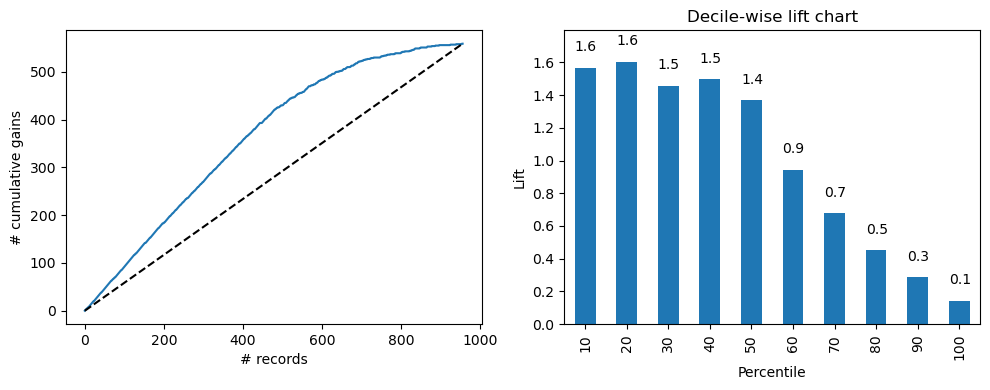

In [206]:
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df.actual, title='Decile-wise lift chart', ax=axes[1])
    
plt.tight_layout()
plt.show()

## Final Model: Logit using selected Predictors

In [217]:
predictors =['DepartureMonth_February', 'SingleGradeTripFlag', 'CRM.Segment_3.0', 'CRM.Segment_11.0', 'Days_7', 
             'CRM.Segment_10.0', 'School.Type_Private non-Christian', 'School.Sponsor', 
             'From.Grade_11.0', 'CRM.Segment_5.0', 'Is.Non.Annual.', 'SPR.New.Existing_NEW', 
             'To.Grade_10.0', 'CRM.Segment_9.0', 'GroupGradeTypeHigh_High', 
             'Days_8', 'Region_Pacific Northwest', 'CRM.Segment_7.0', 'CRM.Segment_2.0', 'Travel.Type_Other_Travel.Type', 
             'SPR.Product.Type_Costa Rica', 'SchoolSizeIndicator_S', 'MajorProgramCode_Other_MajorProgramCode' ]
outcome = 'Retained.in.2012.'

#Partition
X = df2[predictors]
y = df2[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)


In [218]:
# fit a logistic regression (set penalty=l2 (a penalty of L2 will force some coefficients to be small, 
#essentially focusing on a fewer variables) and C=1e42 avoids regularization, C denotes how strong we want 
#regularization to be. A smaller C will make regularization stronger ) Lasso regression
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

#Get intercepts, coefficients, and AIC (Akaike Intuitive Criterion)
print('intercept ', logit_reg.intercept_[0])

# Set options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
coefficients_df=pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns)
coefficients_df.to_csv('logistic_regression_coefficients.csv', index=True)


print() #Creates a Line space
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  0.4513498551145982
       DepartureMonth_February  SingleGradeTripFlag  CRM.Segment_3.0  \
coeff                 2.102633              1.11057         1.426462   

       CRM.Segment_11.0    Days_7  CRM.Segment_10.0  \
coeff          1.699338  0.737014          0.817257   

       School.Type_Private non-Christian  School.Sponsor  From.Grade_11.0  \
coeff                           0.736968        0.588377         0.723713   

       CRM.Segment_5.0  Is.Non.Annual.  SPR.New.Existing_NEW  To.Grade_10.0  \
coeff          0.73074       -2.272328              -1.42047      -1.354212   

       CRM.Segment_9.0  GroupGradeTypeHigh_High    Days_8  \
coeff        -1.155466                -0.596426 -0.719044   

       Region_Pacific Northwest  CRM.Segment_7.0  CRM.Segment_2.0  \
coeff                 -0.606798        -0.274748        -0.021128   

       Travel.Type_Other_Travel.Type  SPR.Product.Type_Costa Rica  \
coeff                      -1.508005                    -1.037605   


In [219]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

# display four different cases
interestingCases = [1, 200, 456, 784]
print(logit_result.loc[interestingCases])

     actual      p(0)      p(1)  predicted
1       1.0  0.042444  0.957556        1.0
200     1.0  0.091733  0.908267        1.0
456     1.0  0.294799  0.705201        1.0
784     1.0  0.091733  0.908267        1.0


In [220]:
#Use the classification summary function for training and validation data
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.7971)

       Prediction
Actual   0   1
     0 278 119
     1  75 484


## New Data Prediction based on final model

In [221]:
# Copy the row at index 0 to create a new row
new_data_point = X.iloc[0].copy()

# Exclude 'Retained.in.2012.' from the modified row
new_data_point.drop('Retained.in.2012.', inplace=True, errors='ignore')

# Alter specific columns for the new data point

new_data_point['School.Sponsor'] = 0
new_data_point['SingleGradeTripFlag'] = 0
new_data_point['Is.Non.Annual.'] = 1
new_data_point = np.array(new_data_point).reshape(1, -1)
new_data_point

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0]], dtype=object)

In [224]:
logit_reg_pred = logit_reg.predict(new_data_point)
logit_reg_proba = logit_reg.predict_proba(new_data_point)
logit_result = pd.DataFrame({ 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                              'predicted': logit_reg_pred })
logit_result

,p(0),p(1),predicted
0,0.860683,0.139317,0.0
